# Summary
## Implementing Support Vector Machines

The following jupyter notebook implements the 4 different kernels in support vector machines, i.e. 'linear', 'poly', 'rbf', and 'sigmoid' to six different transformer models namely 'bert-base-cased', 'bert-base-uncased', 'bert-large-cased', 'bert-large-uncased', 'distilbert-base-cased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'distilroberta-base', 'facebook/bart-base', 'google/bigbird-roberta-base', 'google/bigbird-roberta-large'.

The 'distilbert-base-cased' and 'distilroberta-base' models provide the best clusters as seen from plotting the first two principal components of the datasets pre-processed using these two transformer models.

The SVM classifier with a poly kernel with pre-processing done using the 'distilroberta-base', 'distilbert-base-cased' and 'roberta-large' had a recall of 1. The 'distilroberta-base' with a poly kernel SVM had the highest metrics with a 74.77% accuracy, 67.05% precision and a recall of 1.

In [2]:
## Importing all relevant libraries

import random
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

from transformers import pipeline
from transformers import AutoTokenizer, AutoModel

import torch

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
## Setting a random seed, this will be the seed for all our random_state seeds
random.seed(65432)

In [4]:
df = pd.read_excel("/project/class/bii_sdad_dspg/uva_2021/binn/Data_600_Labeled_Final.xlsx", index_col=0) ## Reading in data
df_save = df.reset_index(inplace=False, drop = True)
#df = df[['full_text', 'YN_INNOVATION']].reset_index(inplace=False, drop = True)
df = df.reset_index(inplace=False, drop = True)

In [5]:
## Balancing target class 

df_yes = df[df.YN_INNOVATION == 'yes']
df_no = df[df.YN_INNOVATION == 'no']

if len(df_yes) == len(df_no):
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_yes) > len(df_no):
    df_yes = df_yes.sample(n=len(df_no), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_no) > len(df_yes):
    df_no = df_no.sample(n=len(df_yes), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
df = df.sample(n=len(df), random_state = 65432).reset_index(inplace=False, drop = True)

    
print("Value counts for target variable:\n",df.YN_INNOVATION.value_counts())

## Encoding target variable

le = preprocessing.LabelEncoder()
df.YN_INNOVATION = le.fit_transform(df.YN_INNOVATION)
print("\n\n\nThe target variable classes are:", le.classes_)

Value counts for target variable:
 yes    222
no     222
Name: YN_INNOVATION, dtype: int64



The target variable classes are: ['no' 'yes']


In [6]:
df.head()

an  \
0  PNN0000020190821ef8k0000w   
1  HTAUGN0020150815eb8d0000r   
2  ENTCUP0020130424e94o00027   
3  ICROWDN020190607ef67000hd   
4  PZON000020170602ed620001y   

                                               title  \
0  Biz4Solutions Shines Amongst The Top 10 Mobile...   
1  Australia: Infor (US) Owns Trademark for 'INFO...   
2  Research and Markets Adds Report: The Future o...   
3  ATCorp Announces Virtual, Online Cyber Securit...   
4  Daktronics Announces Quarterly Cash Dividend p...   

                                             snippet  \
0  August 14, 2019 - Develo4u.co, world's best pl...   
1  Australia, Aug. 13 -- Infor (US) Inc., Blank R...   
2  Research and Markets has announced the additio...   
3  EDEN PRAIRIE, Minn., — Architecture Technology...   
4  Daktronics Announces Quarterly Cash Dividend p...   

                                                body  \
0  Develo4u.co lists these companies based on a t...   
1  Classes: 9 [Computer programs and software for...   
2  Product Synopsis\n\nThe Future of the Prepared...   
3  CYRIN Now incorporates three levels of service...   
4  The quarterly dividend will be payable on June...   

                                           full_text  \
0  Biz4Solutions Shines Amongst The Top 10 Mobile...   
1  Australia: Infor (US) Owns Trademark for 'INFO...   
2  Research and Markets Adds Report: The Future o...   
3  ATCorp Announces Virtual, Online Cyber Securit...   
4  Daktronics Announces Quarterly Cash Dividend p...   

   Does it mention an innovation (yes,no,unsure)?  What is the company?  \
0                                             NaN                   NaN   
1                                             NaN                   NaN   
2                                             NaN                   NaN   
3                                             NaN                   NaN   
4                                             NaN                   NaN   

   Where is company mentioned (title,body,snippet,all)?  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   What is the product name?  \
0                        NaN   
1                        NaN   
2                        NaN   
3                        NaN   
4                        NaN   

   Where is the product name mentioned(title,body,snippet,all)  \
0                                                NaN             
1                                                NaN             
2                                                NaN             
3                                                NaN             
4                                                NaN             

   What could indicate that this is a product (for use in our algorithms, e.g. TM,R,C,CAPITAL LETTERS, Quotes,Used with certain key phrases or words etc.)?  \
0                                                NaN                                                                                                          
1                                                NaN                                                                                                          
2                                                NaN                                                                                                          
3                                                NaN                                                                                                          
4                                                NaN                                                                                                          

   Features of the product, if mentioned assignee  YN_INNOVATION  
0                                    NaN    Aditi              0  


In [6]:
## NLP Models from Hugging Face, pretrained_weights object is changed according to required model
model_class, tokenizer_class, pretrained_weights = (AutoModel, 
                                                    AutoTokenizer, 
                                                    ['bert-base-cased', 'bert-base-uncased', 'bert-large-cased', 'bert-large-uncased', 'distilbert-base-cased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'distilroberta-base', 'facebook/bart-base', 'google/bigbird-roberta-base', 'google/bigbird-roberta-large'])

In [8]:
## NLP Models from Hugging Face, pretrained_weights object is changed according to required model
model_class, tokenizer_class, pretrained_weights = (AutoModel,
                                                    AutoTokenizer, ['distilbert-base-cased', 'distilbert-base-uncased', 'google/bigbird-roberta-base'])

In [9]:
pca_dict = {} ## Empty dict to store PCA components
features_dict = {} ## Empty dict to store features
for weights in pretrained_weights:
    # Load pretrained model/tokenizer
    
    tokenizer = tokenizer_class.from_pretrained(weights)
    
    model = model_class.from_pretrained(weights)
    
    ## Tokenization
    tokenized = df['full_text'].apply((lambda x: tokenizer.encode(x,
                                                                  add_special_tokens=True, 
                                                                  truncation=True,
                                                                  max_length=512)))
    ## Padding
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    
    ## Attention Mask
    attention_mask = np.where(padded != 0, 1, 0)
    print("The shape of the attention mask is:", attention_mask.shape, "for", weights)
    
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    ## Features
    features = last_hidden_states[0][:,0,:].numpy()
    features_dict.update({weights:features})
    
    ## PCA
    # Scale data befor applying PCA
    scaling = StandardScaler()
    # Use fit and transform method 
    scaling.fit(features)
    Scaled_data = scaling.transform(features)
    #Scaled_data = features
    
    # Set the n_components=3
    principal = PCA(n_components=3)
    principal.fit(Scaled_data)
    x = principal.transform(Scaled_data)
    
    ## Appeding PCA output to dict with keys as model names
    pca_dict.update({weights:x})   

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for distilbert-base-cased


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for distilbert-base-uncased


Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.b

The shape of the attention mask is: (444, 512) for google/bigbird-roberta-base


In [10]:
labels = df.YN_INNOVATION ## Target variable

bert-base-cased


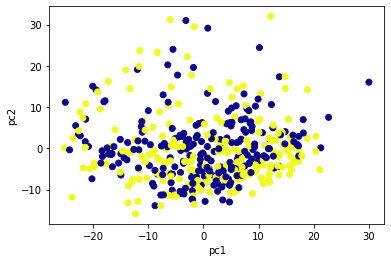

bert-base-uncased


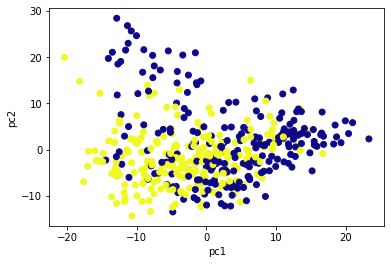

bert-large-cased


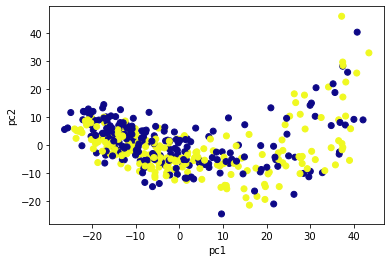

bert-large-uncased


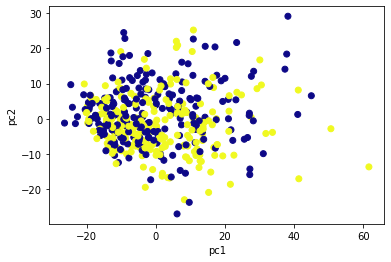

distilbert-base-cased


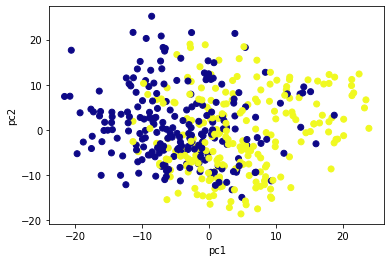

distilbert-base-uncased


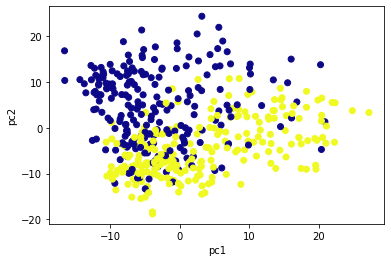

roberta-base


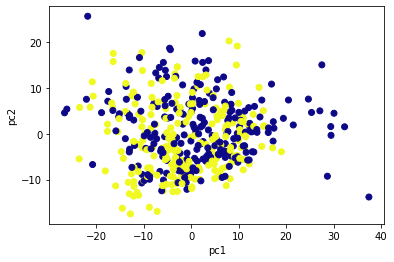

roberta-large


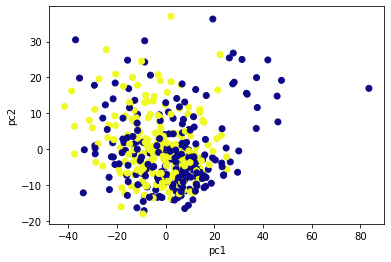

distilroberta-base


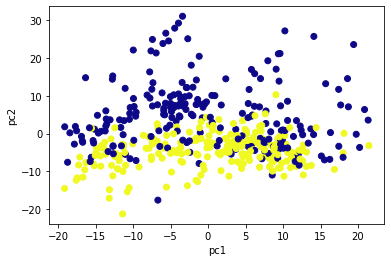

facebook/bart-base


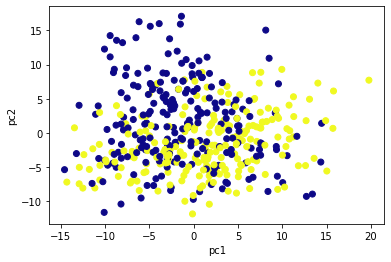

google/bigbird-roberta-base


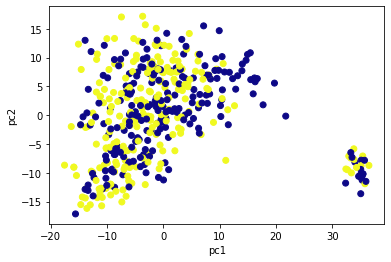

google/bigbird-roberta-large


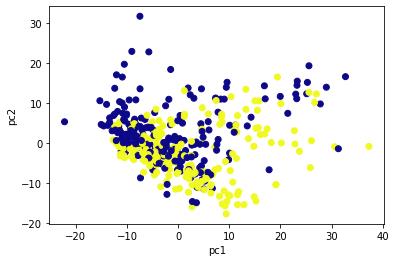

In [9]:
for key, x in pca_dict.items():
    print(key)
    plt.scatter(x[:,0],x[:,1],c=df.YN_INNOVATION,cmap='plasma')
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.show()

bert-base-cased


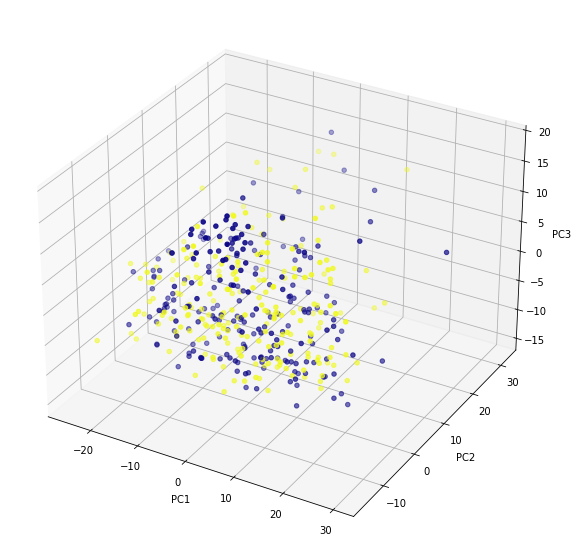

bert-base-uncased


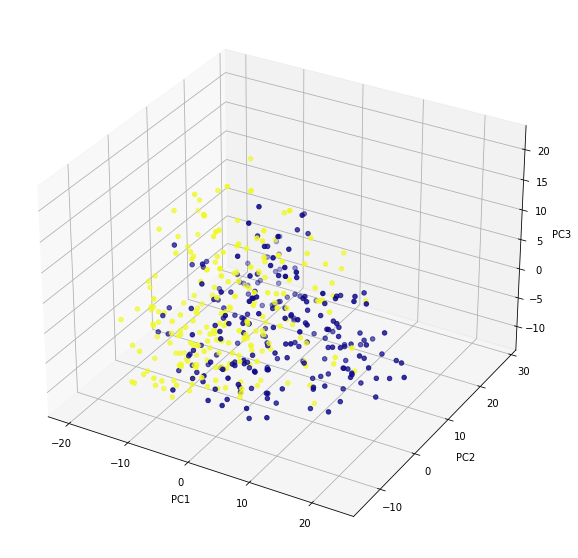

bert-large-cased


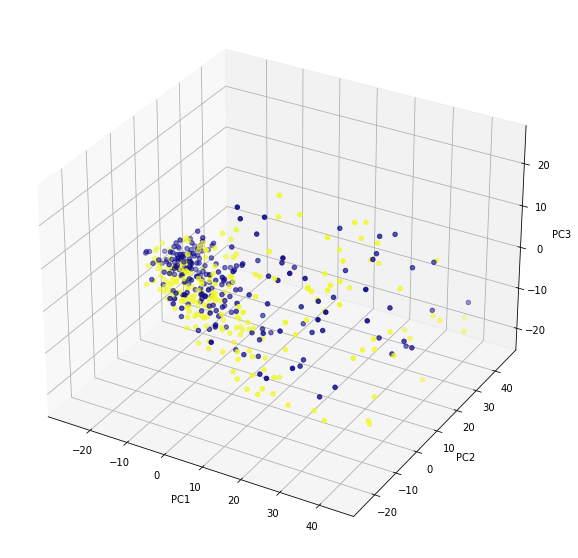

bert-large-uncased


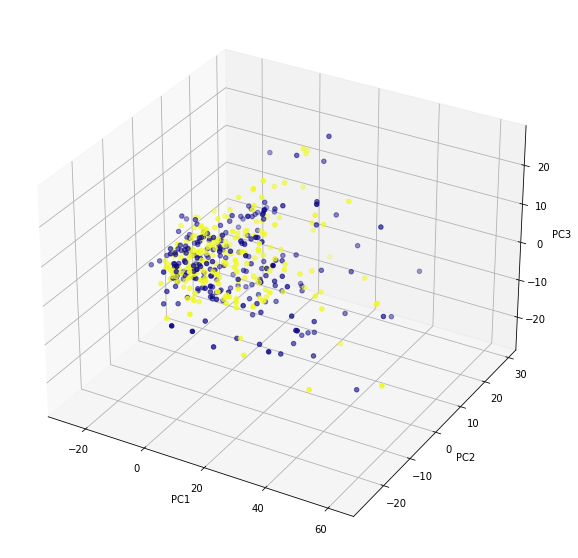

distilbert-base-cased


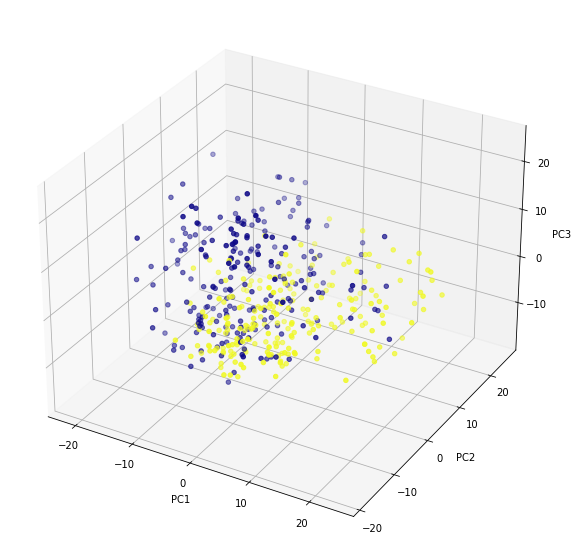

distilbert-base-uncased


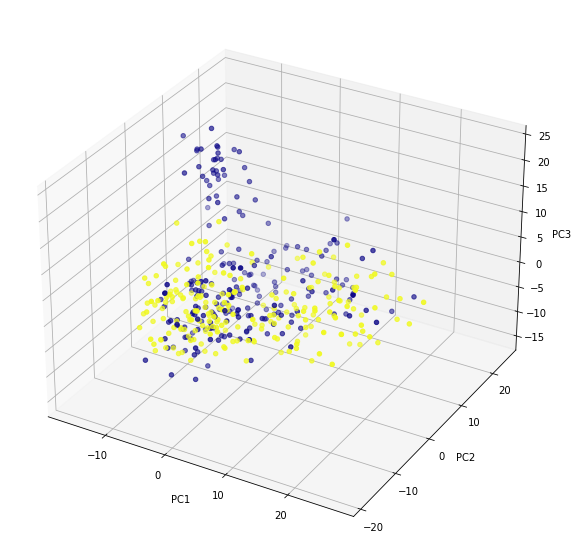

roberta-base


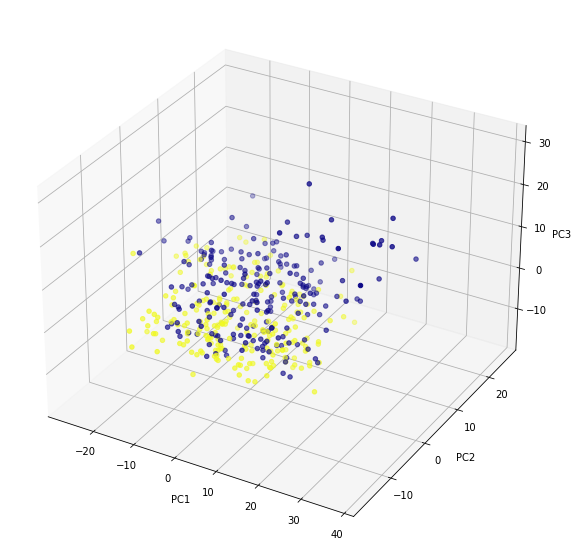

roberta-large


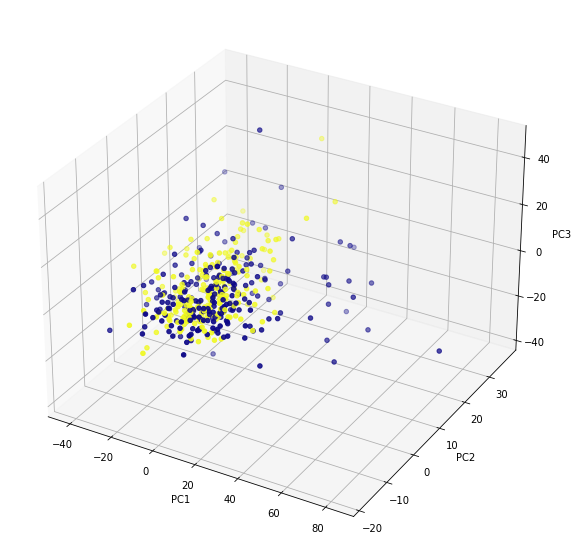

distilroberta-base


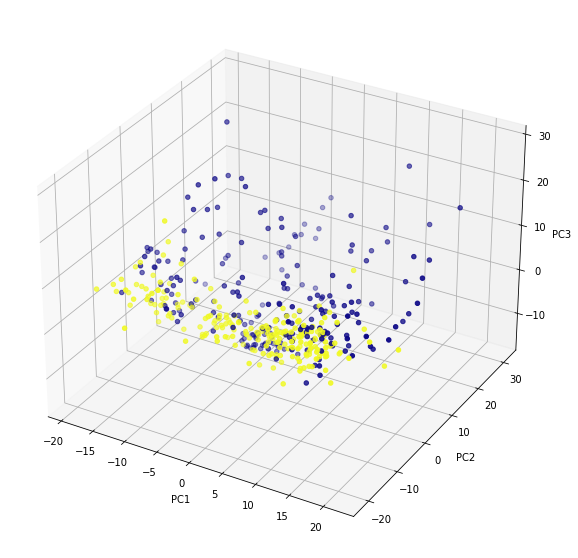

facebook/bart-base


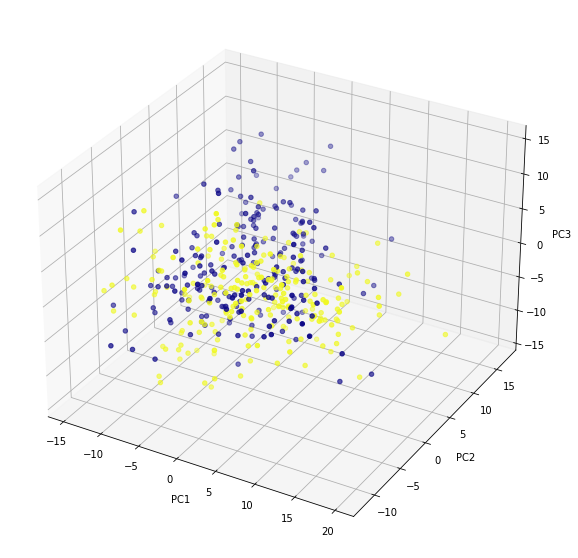

google/bigbird-roberta-base


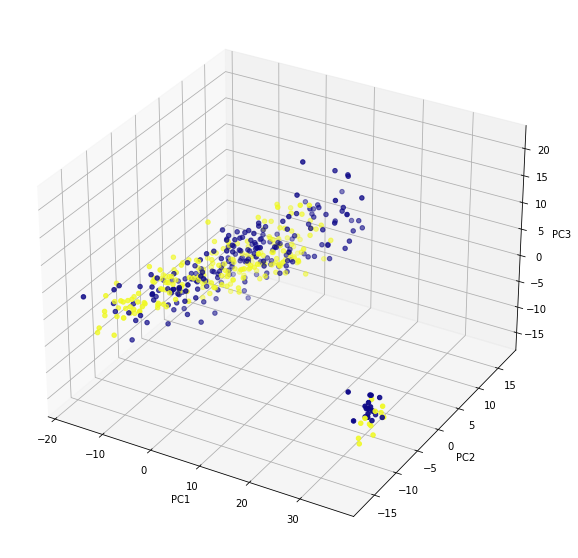

google/bigbird-roberta-large


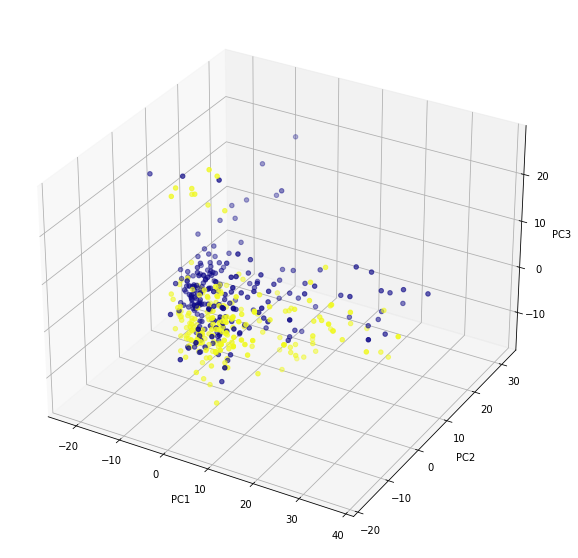

In [10]:
for key, x in pca_dict.items():
    print(key)

    fig = plt.figure(figsize=(10,10))
  
    # choose projection 3d for creating a 3d graph
    axis = fig.add_subplot(111, projection='3d')
  
    # x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3

    axis.scatter(x[:,0],x[:,1],x[:,2], c=df.YN_INNOVATION,cmap='plasma')

    axis.set_xlabel("PC1", fontsize=10)

    axis.set_ylabel("PC2", fontsize=10)

    axis.set_zlabel("PC3", fontsize=10)
    plt.show()

In [12]:
## Splitting th data into train and test sets of features and target
train_features_dict = {}
test_features_dict = {}
train_labels_dict = {}
test_labels_dict = {}

for weights, features in features_dict.items():
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 65432)
    train_features_dict.update({weights:train_features})
    test_features_dict.update({weights:test_features})
    train_labels_dict.update({weights:train_labels})
    test_labels_dict.update({weights:test_labels})

In [ ]:
## NLP Models from Hugging Face, pretrained_weights object is changed according to required model
model_class, tokenizer_class, pretrained_weights = (AutoModel, 
                                                    AutoTokenizer, 
                                                    ['bert-base-cased', 'bert-base-uncased', 'bert-large-cased', 'bert-large-uncased', 'distilbert-base-cased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'distilroberta-base', 'facebook/bart-base', 'google/bigbird-roberta-base', 'google/bigbird-roberta-large'])

In [13]:
test_labels_predict_dict = {}
test_labels_predict_proba_dict = {}

kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']

for key in features_dict.keys():
    for kernel in kernel_list:
        clf = make_pipeline(StandardScaler(), svm.SVC(kernel = kernel, probability=True, random_state = 65432))
        #scores = cross_val_score(clf, features_dict[key], labels, cv=10)
        #scores = np.mean(scores)
        #cv_scores_dict.update({key+"_"+kernel+"-kernel":scores})
        clf.fit(train_features_dict[key],train_labels_dict[key])
        predicted_y = clf.predict(test_features_dict[key])
        pred_prob = clf.predict_proba(test_features_dict[key])[:, 1]
        test_labels_predict_dict.update({key+"_"+kernel+"-kernel":predicted_y})
        test_labels_predict_proba_dict.update({key+"_"+kernel+"-kernel":pred_prob})

In [13]:
df_save[df_save.YN_INNOVATION != "TOSS"].YN_INNOVATION

0      yes
1       no
2       no
3       no
4       no
      ... 
595     no
596    yes
597     no
598    yes
599     no
Name: YN_INNOVATION, Length: 599, dtype: object

In [ ]:
## Cross validating with df_save 600 observations

cv_scores_dict = {}
features_dict = {} ## Empty dict to store features
labels = le.fit_transform(df_save[df_save.YN_INNOVATION != "TOSS"].YN_INNOVATION) ## Target variable

for weights in pretrained_weights:
    # Load pretrained model/tokenizer
    
    tokenizer = tokenizer_class.from_pretrained(weights)
    
    model = model_class.from_pretrained(weights)
    
    ## Tokenization
    tokenized = df_save[df_save.YN_INNOVATION != "TOSS"]['full_text'].apply((lambda x: tokenizer.encode(x,
                                                                  add_special_tokens=True, 
                                                                  truncation=True,
                                                                  max_length=512)))
    ## Padding
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    
    ## Attention Mask
    attention_mask = np.where(padded != 0, 1, 0)
    print("The shape of the attention mask is:", attention_mask.shape, "for", weights)
    
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    ## Features
    features = last_hidden_states[0][:,0,:].numpy()
    features_dict.update({weights:features})
    
    
for key in features_dict.keys():
    for kernel in kernel_list:
        clf = make_pipeline(StandardScaler(), svm.SVC(kernel = kernel, probability=True, random_state = 65432))
        scores = cross_val_score(clf, features_dict[key], labels, cv=10)
        scores = np.mean(scores)
        cv_scores_dict.update({key+"_"+kernel+"-kernel":scores})


========= bert-base-cased_linear-kernel model ==========

Accuracy of the of the bert-base-cased_linear-kernel model is 78.38%.
Precision rate of the bert-base-cased_linear-kernel model is 80.0%.
Recall rate of the bert-base-cased_linear-kernel model is 77.19%.
F-1 score of the bert-base-cased_linear-kernel model is 78.57%.

The confusion matrix for the bert-base-cased_linear-kernel model is:


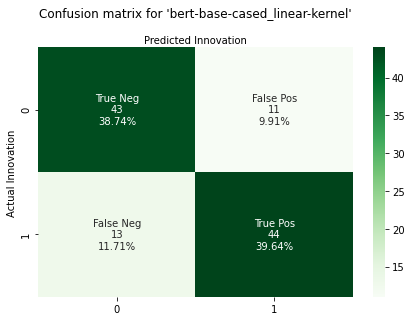

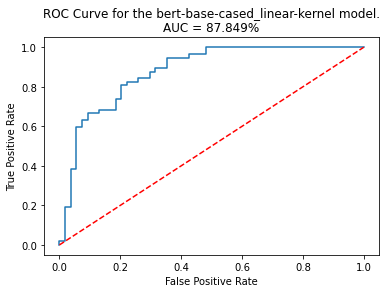


========= bert-base-cased_poly-kernel model ==========

Accuracy of the of the bert-base-cased_poly-kernel model is 67.57%.
Precision rate of the bert-base-cased_poly-kernel model is 64.0%.
Recall rate of the bert-base-cased_poly-kernel model is 84.21%.
F-1 score of the bert-base-cased_poly-kernel model is 72.73%.

The confusion matrix for the bert-base-cased_poly-kernel model is:


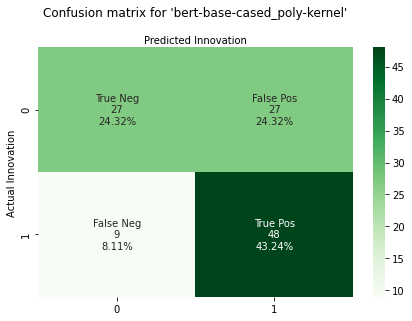

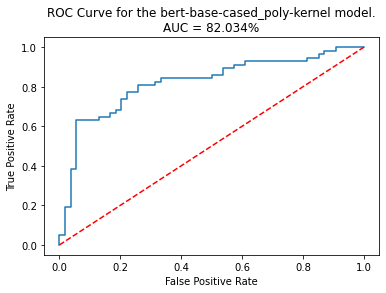


========= bert-base-cased_rbf-kernel model ==========

Accuracy of the of the bert-base-cased_rbf-kernel model is 81.08%.
Precision rate of the bert-base-cased_rbf-kernel model is 80.0%.
Recall rate of the bert-base-cased_rbf-kernel model is 84.21%.
F-1 score of the bert-base-cased_rbf-kernel model is 82.05%.

The confusion matrix for the bert-base-cased_rbf-kernel model is:


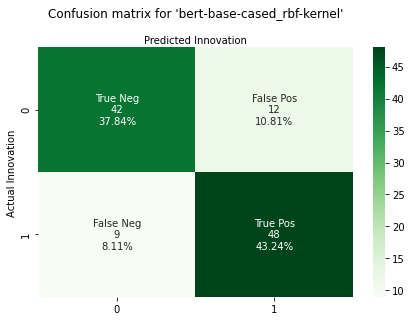

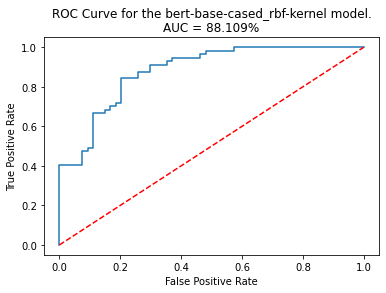


========= bert-base-cased_sigmoid-kernel model ==========

Accuracy of the of the bert-base-cased_sigmoid-kernel model is 80.18%.
Precision rate of the bert-base-cased_sigmoid-kernel model is 76.92%.
Recall rate of the bert-base-cased_sigmoid-kernel model is 87.72%.
F-1 score of the bert-base-cased_sigmoid-kernel model is 81.97%.

The confusion matrix for the bert-base-cased_sigmoid-kernel model is:


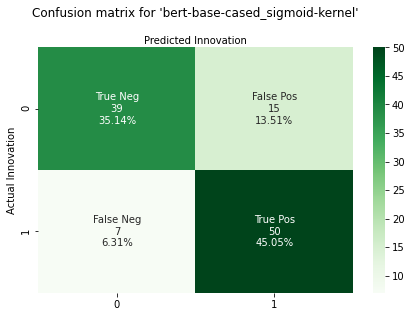

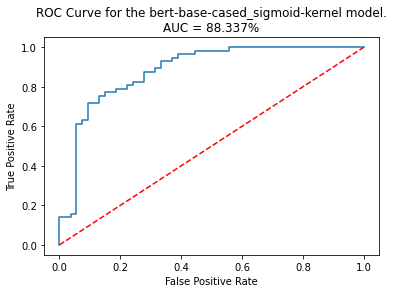


========= bert-base-uncased_linear-kernel model ==========

Accuracy of the of the bert-base-uncased_linear-kernel model is 79.28%.
Precision rate of the bert-base-uncased_linear-kernel model is 76.56%.
Recall rate of the bert-base-uncased_linear-kernel model is 85.96%.
F-1 score of the bert-base-uncased_linear-kernel model is 80.99%.

The confusion matrix for the bert-base-uncased_linear-kernel model is:


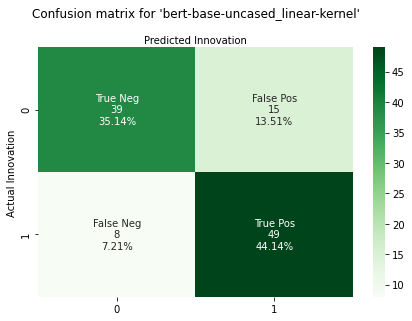

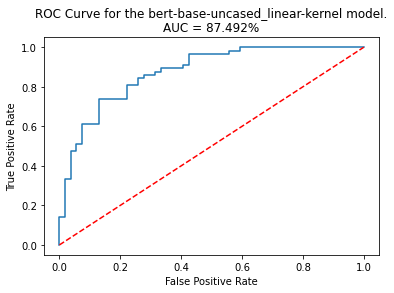


========= bert-base-uncased_poly-kernel model ==========

Accuracy of the of the bert-base-uncased_poly-kernel model is 76.58%.
Precision rate of the bert-base-uncased_poly-kernel model is 69.62%.
Recall rate of the bert-base-uncased_poly-kernel model is 96.49%.
F-1 score of the bert-base-uncased_poly-kernel model is 80.88%.

The confusion matrix for the bert-base-uncased_poly-kernel model is:


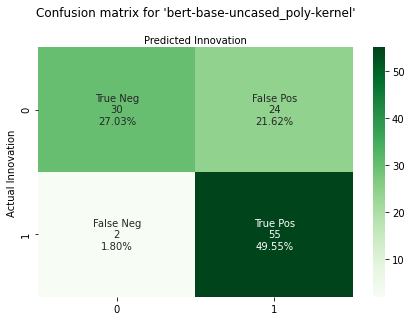

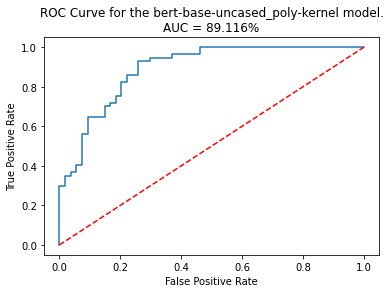


========= bert-base-uncased_rbf-kernel model ==========

Accuracy of the of the bert-base-uncased_rbf-kernel model is 79.28%.
Precision rate of the bert-base-uncased_rbf-kernel model is 77.42%.
Recall rate of the bert-base-uncased_rbf-kernel model is 84.21%.
F-1 score of the bert-base-uncased_rbf-kernel model is 80.67%.

The confusion matrix for the bert-base-uncased_rbf-kernel model is:


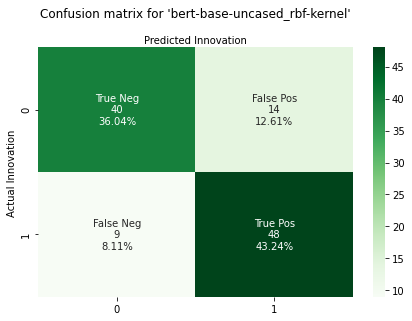

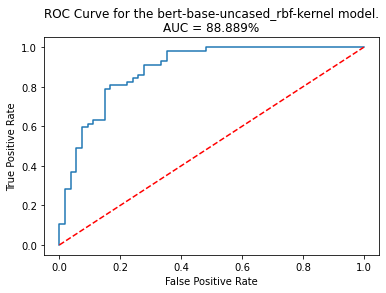


========= bert-base-uncased_sigmoid-kernel model ==========

Accuracy of the of the bert-base-uncased_sigmoid-kernel model is 81.98%.
Precision rate of the bert-base-uncased_sigmoid-kernel model is 76.81%.
Recall rate of the bert-base-uncased_sigmoid-kernel model is 92.98%.
F-1 score of the bert-base-uncased_sigmoid-kernel model is 84.13%.

The confusion matrix for the bert-base-uncased_sigmoid-kernel model is:


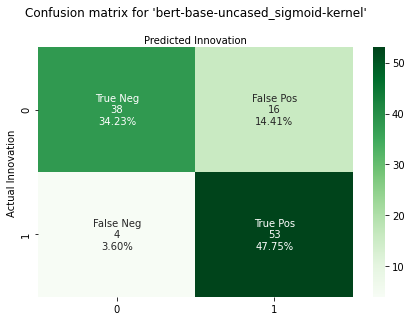

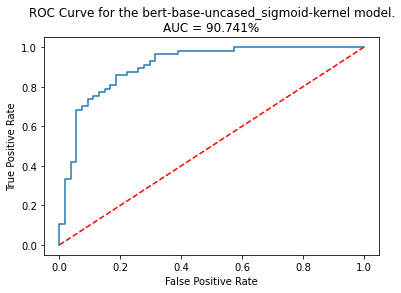


========= bert-large-cased_linear-kernel model ==========

Accuracy of the of the bert-large-cased_linear-kernel model is 72.97%.
Precision rate of the bert-large-cased_linear-kernel model is 72.88%.
Recall rate of the bert-large-cased_linear-kernel model is 75.44%.
F-1 score of the bert-large-cased_linear-kernel model is 74.14%.

The confusion matrix for the bert-large-cased_linear-kernel model is:


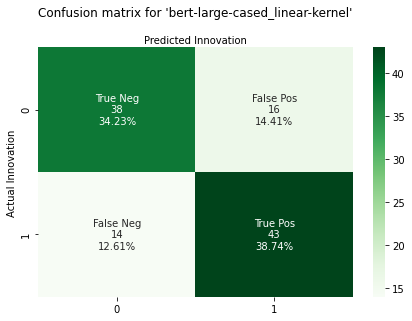

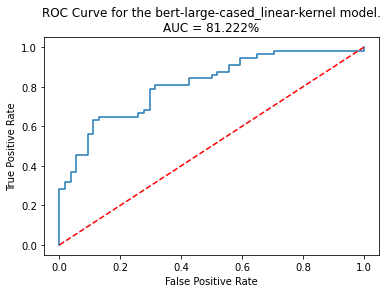


========= bert-large-cased_poly-kernel model ==========

Accuracy of the of the bert-large-cased_poly-kernel model is 59.46%.
Precision rate of the bert-large-cased_poly-kernel model is 77.27%.
Recall rate of the bert-large-cased_poly-kernel model is 29.82%.
F-1 score of the bert-large-cased_poly-kernel model is 43.04%.

The confusion matrix for the bert-large-cased_poly-kernel model is:


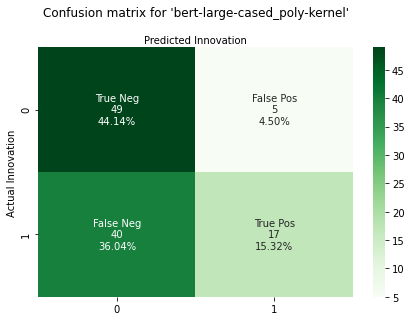

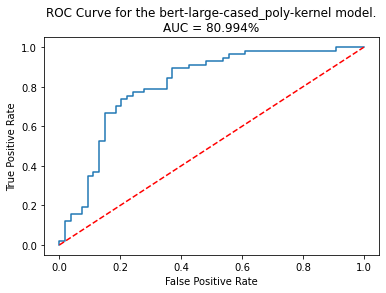


========= bert-large-cased_rbf-kernel model ==========

Accuracy of the of the bert-large-cased_rbf-kernel model is 78.38%.
Precision rate of the bert-large-cased_rbf-kernel model is 75.38%.
Recall rate of the bert-large-cased_rbf-kernel model is 85.96%.
F-1 score of the bert-large-cased_rbf-kernel model is 80.33%.

The confusion matrix for the bert-large-cased_rbf-kernel model is:


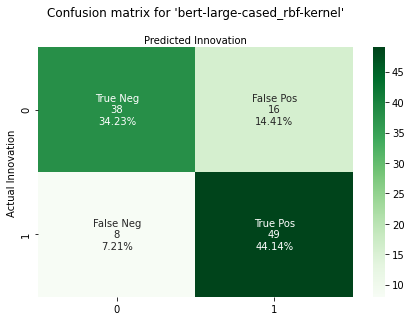

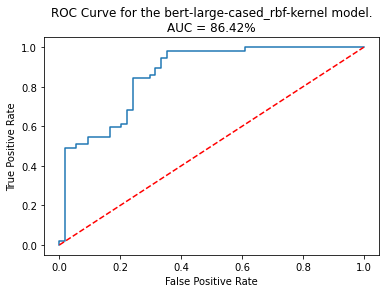


========= bert-large-cased_sigmoid-kernel model ==========

Accuracy of the of the bert-large-cased_sigmoid-kernel model is 77.48%.
Precision rate of the bert-large-cased_sigmoid-kernel model is 78.57%.
Recall rate of the bert-large-cased_sigmoid-kernel model is 77.19%.
F-1 score of the bert-large-cased_sigmoid-kernel model is 77.88%.

The confusion matrix for the bert-large-cased_sigmoid-kernel model is:


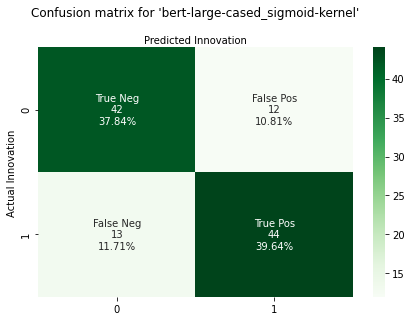

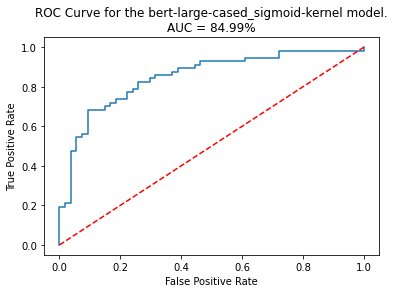


========= bert-large-uncased_linear-kernel model ==========

Accuracy of the of the bert-large-uncased_linear-kernel model is 77.48%.
Precision rate of the bert-large-uncased_linear-kernel model is 75.0%.
Recall rate of the bert-large-uncased_linear-kernel model is 84.21%.
F-1 score of the bert-large-uncased_linear-kernel model is 79.34%.

The confusion matrix for the bert-large-uncased_linear-kernel model is:


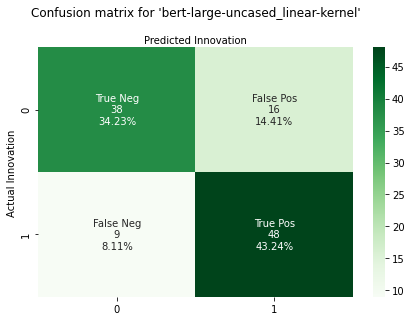

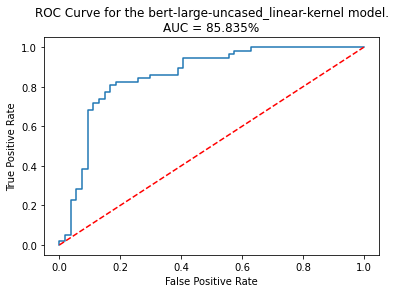


========= bert-large-uncased_poly-kernel model ==========

Accuracy of the of the bert-large-uncased_poly-kernel model is 74.77%.
Precision rate of the bert-large-uncased_poly-kernel model is 67.47%.
Recall rate of the bert-large-uncased_poly-kernel model is 98.25%.
F-1 score of the bert-large-uncased_poly-kernel model is 80.0%.

The confusion matrix for the bert-large-uncased_poly-kernel model is:


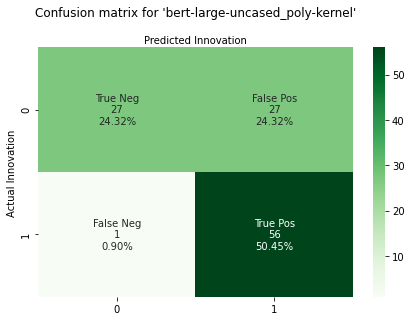

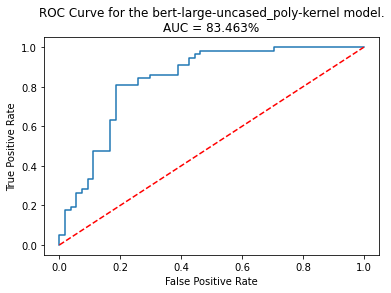


========= bert-large-uncased_rbf-kernel model ==========

Accuracy of the of the bert-large-uncased_rbf-kernel model is 74.77%.
Precision rate of the bert-large-uncased_rbf-kernel model is 73.77%.
Recall rate of the bert-large-uncased_rbf-kernel model is 78.95%.
F-1 score of the bert-large-uncased_rbf-kernel model is 76.27%.

The confusion matrix for the bert-large-uncased_rbf-kernel model is:


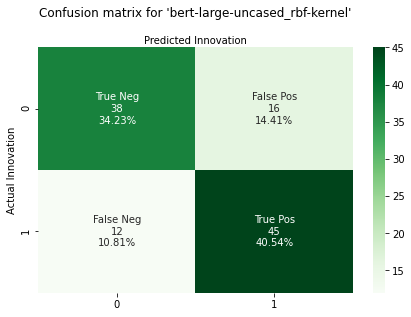

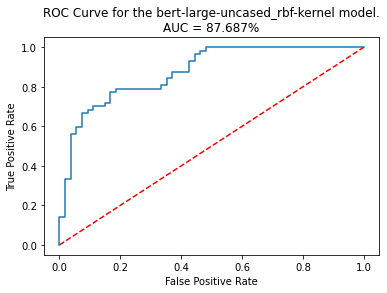


========= bert-large-uncased_sigmoid-kernel model ==========

Accuracy of the of the bert-large-uncased_sigmoid-kernel model is 72.97%.
Precision rate of the bert-large-uncased_sigmoid-kernel model is 70.15%.
Recall rate of the bert-large-uncased_sigmoid-kernel model is 82.46%.
F-1 score of the bert-large-uncased_sigmoid-kernel model is 75.81%.

The confusion matrix for the bert-large-uncased_sigmoid-kernel model is:


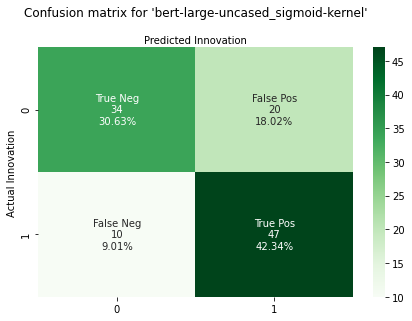

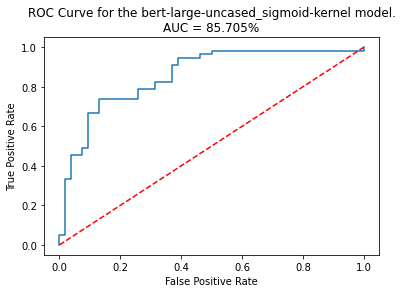


========= distilbert-base-cased_linear-kernel model ==========

Accuracy of the of the distilbert-base-cased_linear-kernel model is 76.58%.
Precision rate of the distilbert-base-cased_linear-kernel model is 77.19%.
Recall rate of the distilbert-base-cased_linear-kernel model is 77.19%.
F-1 score of the distilbert-base-cased_linear-kernel model is 77.19%.

The confusion matrix for the distilbert-base-cased_linear-kernel model is:


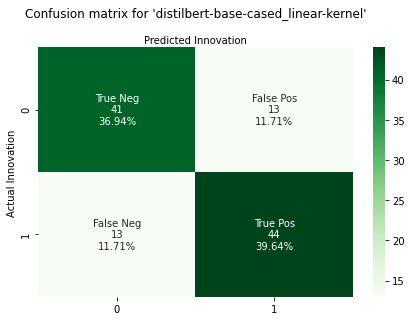

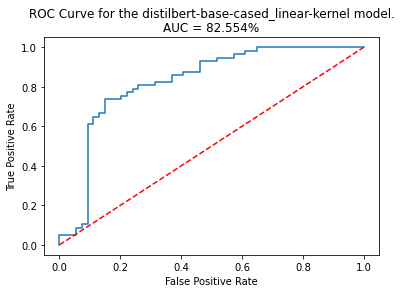


========= distilbert-base-cased_poly-kernel model ==========

Accuracy of the of the distilbert-base-cased_poly-kernel model is 68.47%.
Precision rate of the distilbert-base-cased_poly-kernel model is 61.96%.
Recall rate of the distilbert-base-cased_poly-kernel model is 100.0%.
F-1 score of the distilbert-base-cased_poly-kernel model is 76.51%.

The confusion matrix for the distilbert-base-cased_poly-kernel model is:


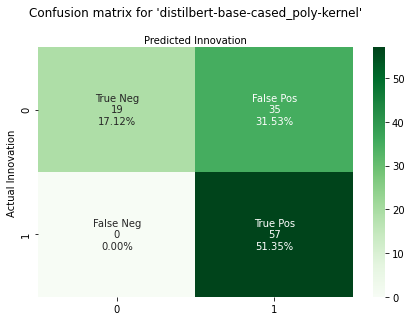

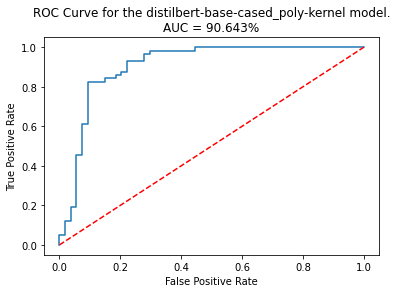


========= distilbert-base-cased_rbf-kernel model ==========

Accuracy of the of the distilbert-base-cased_rbf-kernel model is 83.78%.
Precision rate of the distilbert-base-cased_rbf-kernel model is 78.26%.
Recall rate of the distilbert-base-cased_rbf-kernel model is 94.74%.
F-1 score of the distilbert-base-cased_rbf-kernel model is 85.71%.

The confusion matrix for the distilbert-base-cased_rbf-kernel model is:


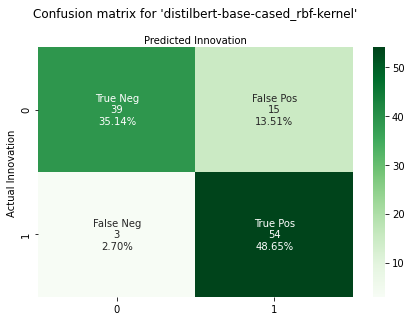

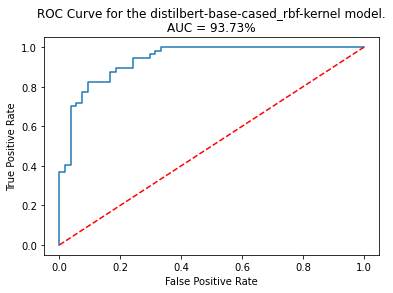


========= distilbert-base-cased_sigmoid-kernel model ==========

Accuracy of the of the distilbert-base-cased_sigmoid-kernel model is 83.78%.
Precision rate of the distilbert-base-cased_sigmoid-kernel model is 79.1%.
Recall rate of the distilbert-base-cased_sigmoid-kernel model is 92.98%.
F-1 score of the distilbert-base-cased_sigmoid-kernel model is 85.48%.

The confusion matrix for the distilbert-base-cased_sigmoid-kernel model is:


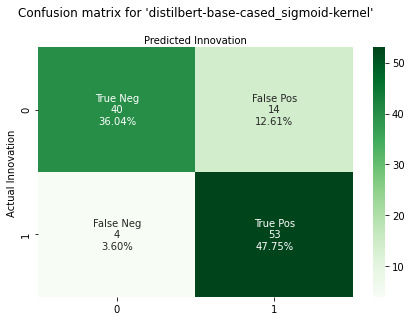

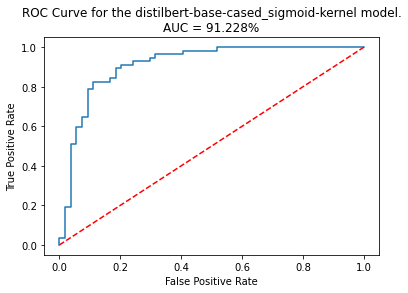


========= distilbert-base-uncased_linear-kernel model ==========

Accuracy of the of the distilbert-base-uncased_linear-kernel model is 81.98%.
Precision rate of the distilbert-base-uncased_linear-kernel model is 82.46%.
Recall rate of the distilbert-base-uncased_linear-kernel model is 82.46%.
F-1 score of the distilbert-base-uncased_linear-kernel model is 82.46%.

The confusion matrix for the distilbert-base-uncased_linear-kernel model is:


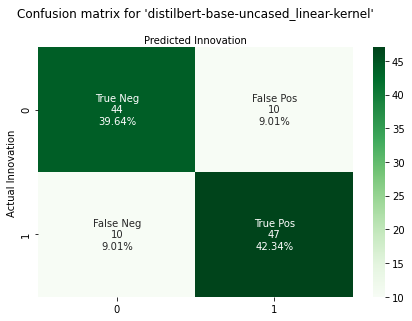

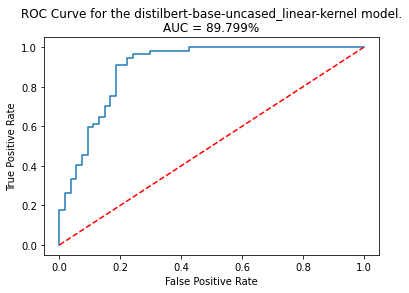


========= distilbert-base-uncased_poly-kernel model ==========

Accuracy of the of the distilbert-base-uncased_poly-kernel model is 78.38%.
Precision rate of the distilbert-base-uncased_poly-kernel model is 70.37%.
Recall rate of the distilbert-base-uncased_poly-kernel model is 100.0%.
F-1 score of the distilbert-base-uncased_poly-kernel model is 82.61%.

The confusion matrix for the distilbert-base-uncased_poly-kernel model is:


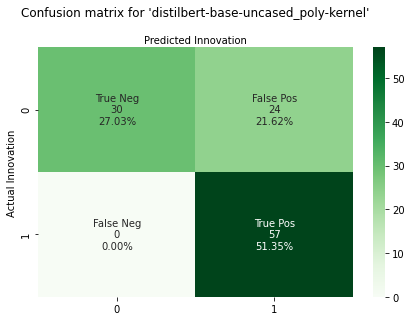

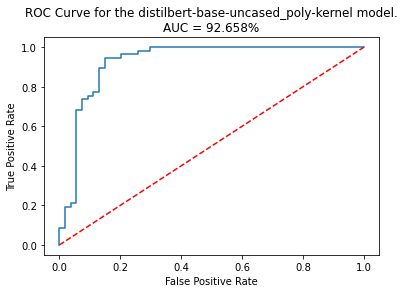


========= distilbert-base-uncased_rbf-kernel model ==========

Accuracy of the of the distilbert-base-uncased_rbf-kernel model is 90.09%.
Precision rate of the distilbert-base-uncased_rbf-kernel model is 83.82%.
Recall rate of the distilbert-base-uncased_rbf-kernel model is 100.0%.
F-1 score of the distilbert-base-uncased_rbf-kernel model is 91.2%.

The confusion matrix for the distilbert-base-uncased_rbf-kernel model is:


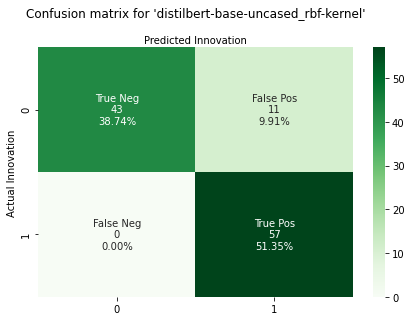

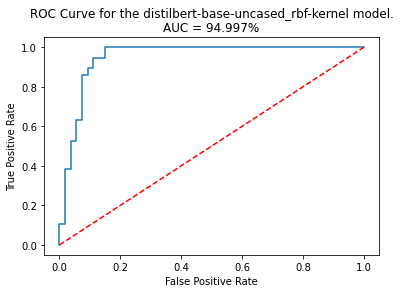


========= distilbert-base-uncased_sigmoid-kernel model ==========

Accuracy of the of the distilbert-base-uncased_sigmoid-kernel model is 89.19%.
Precision rate of the distilbert-base-uncased_sigmoid-kernel model is 83.58%.
Recall rate of the distilbert-base-uncased_sigmoid-kernel model is 98.25%.
F-1 score of the distilbert-base-uncased_sigmoid-kernel model is 90.32%.

The confusion matrix for the distilbert-base-uncased_sigmoid-kernel model is:


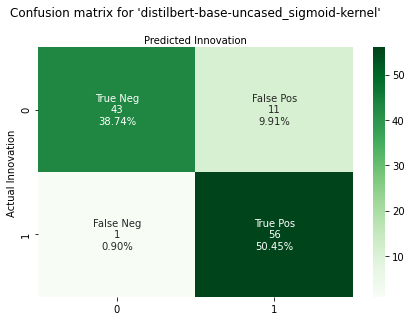

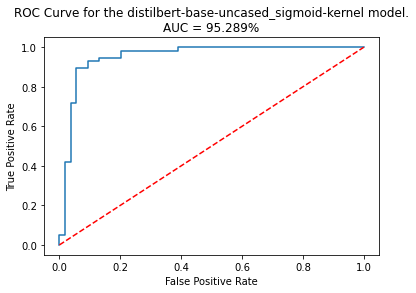


========= roberta-base_linear-kernel model ==========

Accuracy of the of the roberta-base_linear-kernel model is 78.38%.
Precision rate of the roberta-base_linear-kernel model is 77.97%.
Recall rate of the roberta-base_linear-kernel model is 80.7%.
F-1 score of the roberta-base_linear-kernel model is 79.31%.

The confusion matrix for the roberta-base_linear-kernel model is:


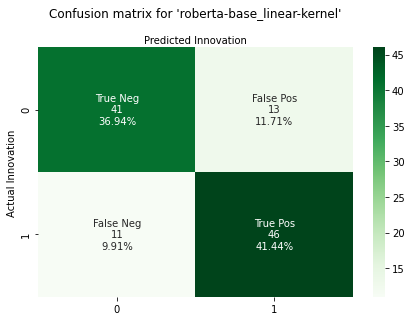

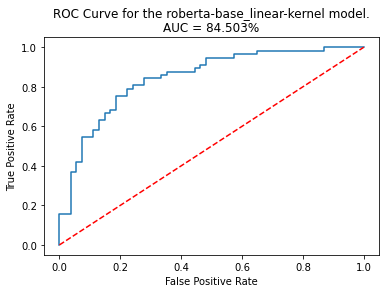


========= roberta-base_poly-kernel model ==========

Accuracy of the of the roberta-base_poly-kernel model is 71.17%.
Precision rate of the roberta-base_poly-kernel model is 64.37%.
Recall rate of the roberta-base_poly-kernel model is 98.25%.
F-1 score of the roberta-base_poly-kernel model is 77.78%.

The confusion matrix for the roberta-base_poly-kernel model is:


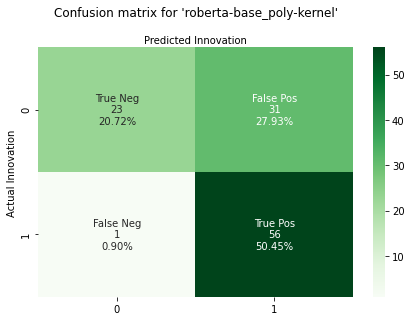

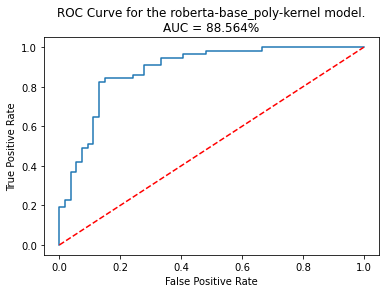


========= roberta-base_rbf-kernel model ==========

Accuracy of the of the roberta-base_rbf-kernel model is 81.98%.
Precision rate of the roberta-base_rbf-kernel model is 78.46%.
Recall rate of the roberta-base_rbf-kernel model is 89.47%.
F-1 score of the roberta-base_rbf-kernel model is 83.61%.

The confusion matrix for the roberta-base_rbf-kernel model is:


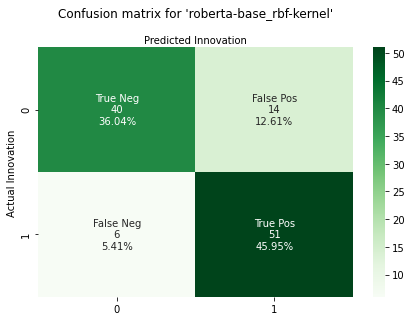

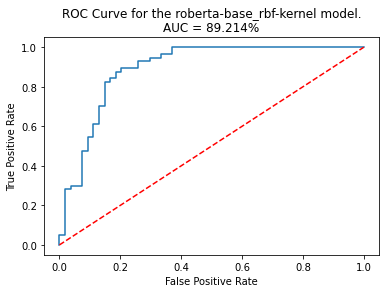


========= roberta-base_sigmoid-kernel model ==========

Accuracy of the of the roberta-base_sigmoid-kernel model is 82.88%.
Precision rate of the roberta-base_sigmoid-kernel model is 79.69%.
Recall rate of the roberta-base_sigmoid-kernel model is 89.47%.
F-1 score of the roberta-base_sigmoid-kernel model is 84.3%.

The confusion matrix for the roberta-base_sigmoid-kernel model is:


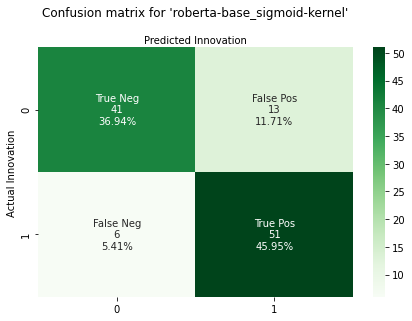

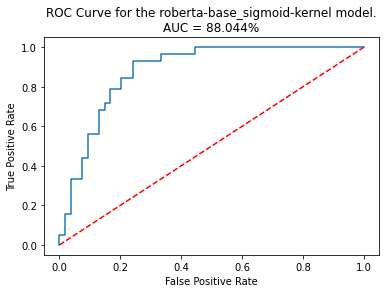


========= roberta-large_linear-kernel model ==========

Accuracy of the of the roberta-large_linear-kernel model is 81.08%.
Precision rate of the roberta-large_linear-kernel model is 81.03%.
Recall rate of the roberta-large_linear-kernel model is 82.46%.
F-1 score of the roberta-large_linear-kernel model is 81.74%.

The confusion matrix for the roberta-large_linear-kernel model is:


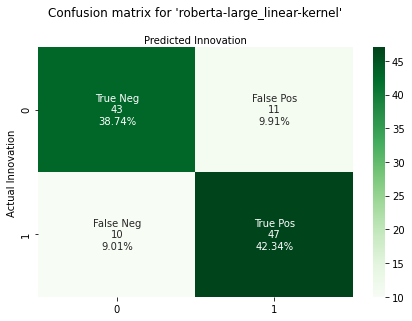

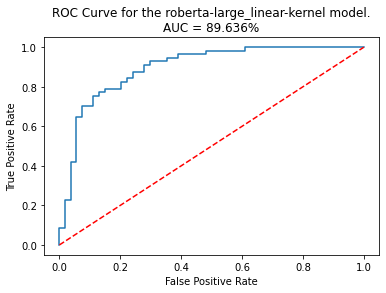


========= roberta-large_poly-kernel model ==========

Accuracy of the of the roberta-large_poly-kernel model is 66.67%.
Precision rate of the roberta-large_poly-kernel model is 60.64%.
Recall rate of the roberta-large_poly-kernel model is 100.0%.
F-1 score of the roberta-large_poly-kernel model is 75.5%.

The confusion matrix for the roberta-large_poly-kernel model is:


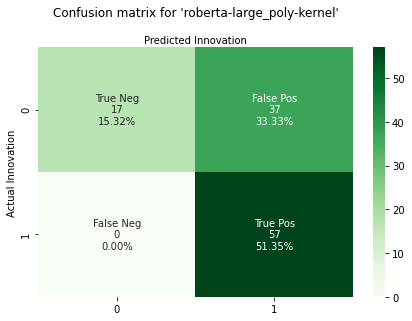

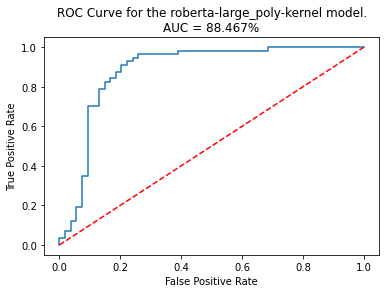


========= roberta-large_rbf-kernel model ==========

Accuracy of the of the roberta-large_rbf-kernel model is 81.98%.
Precision rate of the roberta-large_rbf-kernel model is 78.46%.
Recall rate of the roberta-large_rbf-kernel model is 89.47%.
F-1 score of the roberta-large_rbf-kernel model is 83.61%.

The confusion matrix for the roberta-large_rbf-kernel model is:


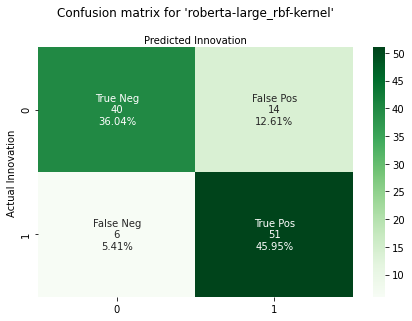

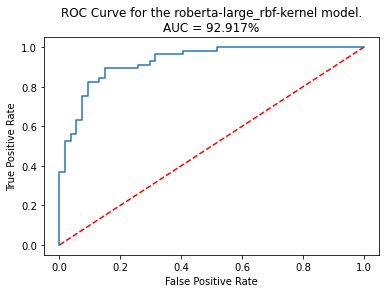


========= roberta-large_sigmoid-kernel model ==========

Accuracy of the of the roberta-large_sigmoid-kernel model is 77.48%.
Precision rate of the roberta-large_sigmoid-kernel model is 74.24%.
Recall rate of the roberta-large_sigmoid-kernel model is 85.96%.
F-1 score of the roberta-large_sigmoid-kernel model is 79.67%.

The confusion matrix for the roberta-large_sigmoid-kernel model is:


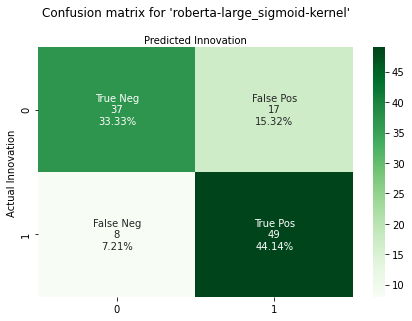

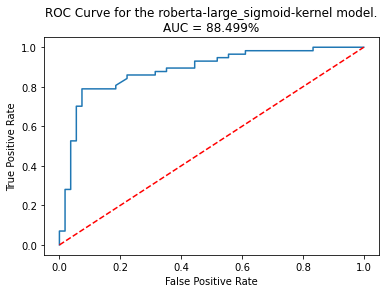


========= distilroberta-base_linear-kernel model ==========

Accuracy of the of the distilroberta-base_linear-kernel model is 77.48%.
Precision rate of the distilroberta-base_linear-kernel model is 74.24%.
Recall rate of the distilroberta-base_linear-kernel model is 85.96%.
F-1 score of the distilroberta-base_linear-kernel model is 79.67%.

The confusion matrix for the distilroberta-base_linear-kernel model is:


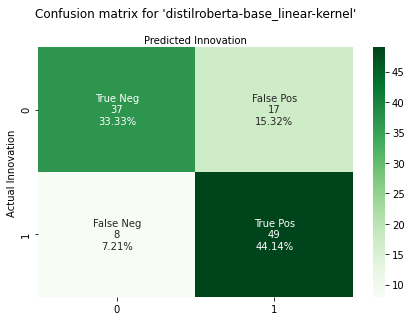

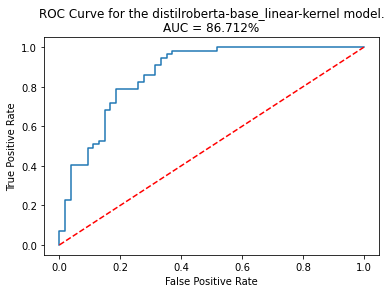


========= distilroberta-base_poly-kernel model ==========

Accuracy of the of the distilroberta-base_poly-kernel model is 74.77%.
Precision rate of the distilroberta-base_poly-kernel model is 67.06%.
Recall rate of the distilroberta-base_poly-kernel model is 100.0%.
F-1 score of the distilroberta-base_poly-kernel model is 80.28%.

The confusion matrix for the distilroberta-base_poly-kernel model is:


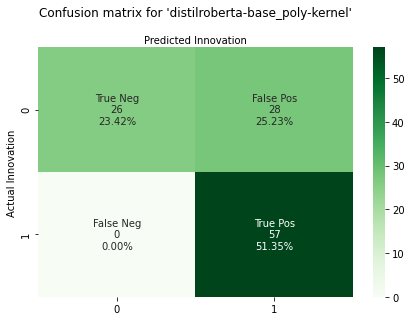

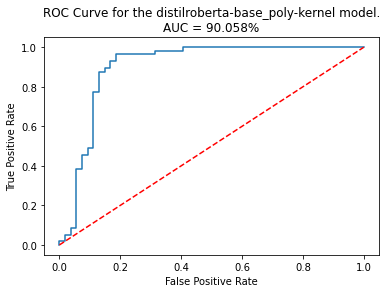


========= distilroberta-base_rbf-kernel model ==========

Accuracy of the of the distilroberta-base_rbf-kernel model is 84.68%.
Precision rate of the distilroberta-base_rbf-kernel model is 79.41%.
Recall rate of the distilroberta-base_rbf-kernel model is 94.74%.
F-1 score of the distilroberta-base_rbf-kernel model is 86.4%.

The confusion matrix for the distilroberta-base_rbf-kernel model is:


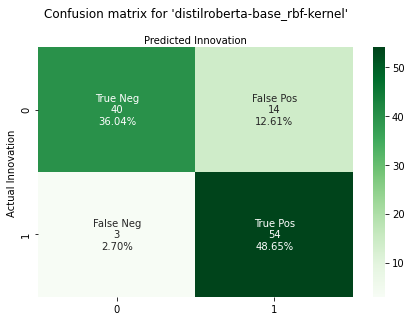

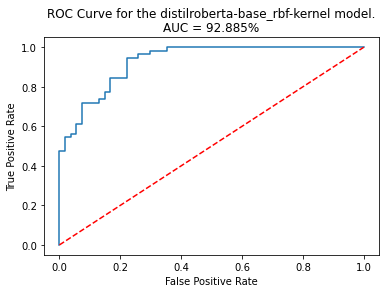


========= distilroberta-base_sigmoid-kernel model ==========

Accuracy of the of the distilroberta-base_sigmoid-kernel model is 86.49%.
Precision rate of the distilroberta-base_sigmoid-kernel model is 81.82%.
Recall rate of the distilroberta-base_sigmoid-kernel model is 94.74%.
F-1 score of the distilroberta-base_sigmoid-kernel model is 87.8%.

The confusion matrix for the distilroberta-base_sigmoid-kernel model is:


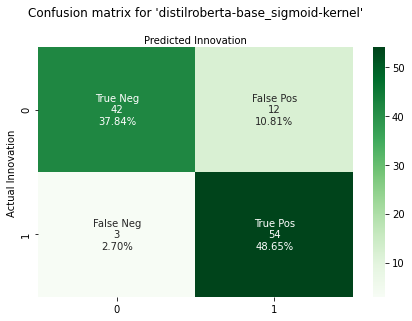

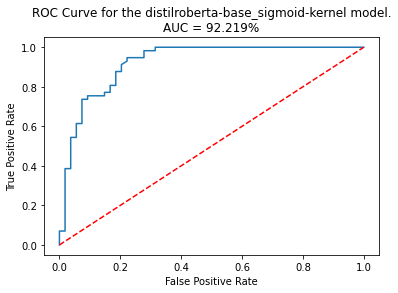


========= facebook/bart-base_linear-kernel model ==========

Accuracy of the of the facebook/bart-base_linear-kernel model is 73.87%.
Precision rate of the facebook/bart-base_linear-kernel model is 72.58%.
Recall rate of the facebook/bart-base_linear-kernel model is 78.95%.
F-1 score of the facebook/bart-base_linear-kernel model is 75.63%.

The confusion matrix for the facebook/bart-base_linear-kernel model is:


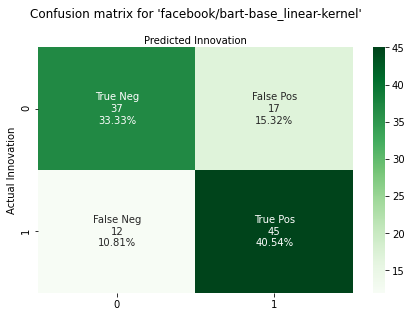

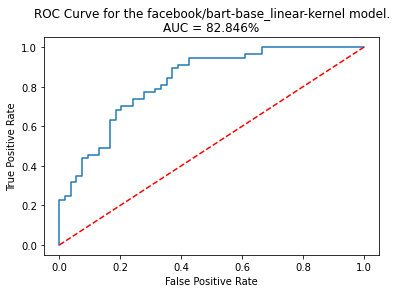


========= facebook/bart-base_poly-kernel model ==========

Accuracy of the of the facebook/bart-base_poly-kernel model is 75.68%.
Precision rate of the facebook/bart-base_poly-kernel model is 69.74%.
Recall rate of the facebook/bart-base_poly-kernel model is 92.98%.
F-1 score of the facebook/bart-base_poly-kernel model is 79.7%.

The confusion matrix for the facebook/bart-base_poly-kernel model is:


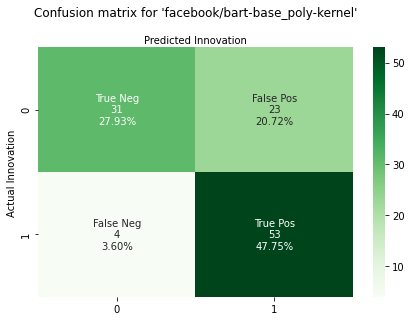

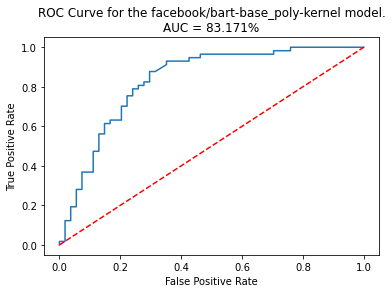


========= facebook/bart-base_rbf-kernel model ==========

Accuracy of the of the facebook/bart-base_rbf-kernel model is 79.28%.
Precision rate of the facebook/bart-base_rbf-kernel model is 75.0%.
Recall rate of the facebook/bart-base_rbf-kernel model is 89.47%.
F-1 score of the facebook/bart-base_rbf-kernel model is 81.6%.

The confusion matrix for the facebook/bart-base_rbf-kernel model is:


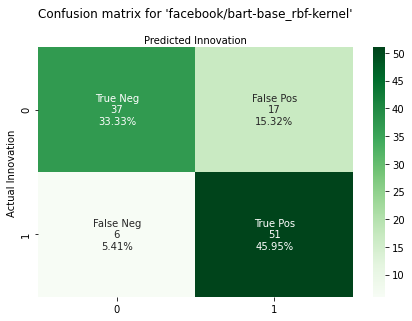

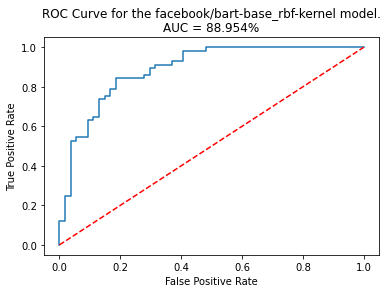


========= facebook/bart-base_sigmoid-kernel model ==========

Accuracy of the of the facebook/bart-base_sigmoid-kernel model is 80.18%.
Precision rate of the facebook/bart-base_sigmoid-kernel model is 76.12%.
Recall rate of the facebook/bart-base_sigmoid-kernel model is 89.47%.
F-1 score of the facebook/bart-base_sigmoid-kernel model is 82.26%.

The confusion matrix for the facebook/bart-base_sigmoid-kernel model is:


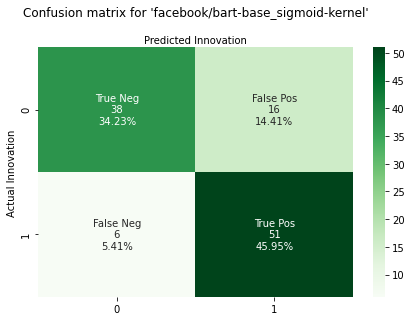

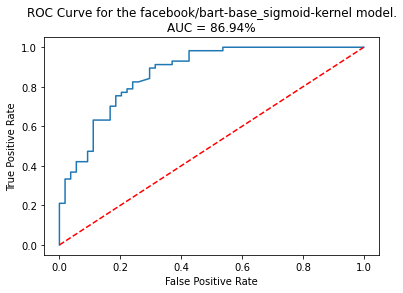


========= google/bigbird-roberta-base_linear-kernel model ==========

Accuracy of the of the google/bigbird-roberta-base_linear-kernel model is 79.28%.
Precision rate of the google/bigbird-roberta-base_linear-kernel model is 78.33%.
Recall rate of the google/bigbird-roberta-base_linear-kernel model is 82.46%.
F-1 score of the google/bigbird-roberta-base_linear-kernel model is 80.34%.

The confusion matrix for the google/bigbird-roberta-base_linear-kernel model is:


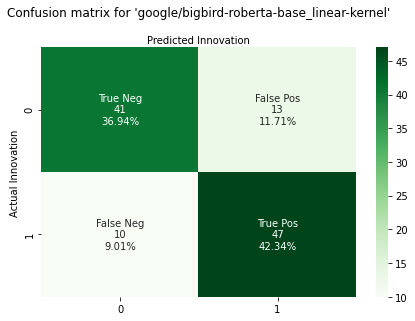

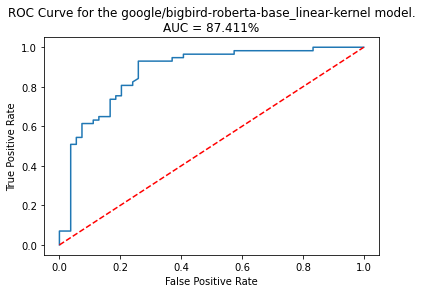


========= google/bigbird-roberta-base_poly-kernel model ==========

Accuracy of the of the google/bigbird-roberta-base_poly-kernel model is 72.97%.
Precision rate of the google/bigbird-roberta-base_poly-kernel model is 65.52%.
Recall rate of the google/bigbird-roberta-base_poly-kernel model is 100.0%.
F-1 score of the google/bigbird-roberta-base_poly-kernel model is 79.17%.

The confusion matrix for the google/bigbird-roberta-base_poly-kernel model is:


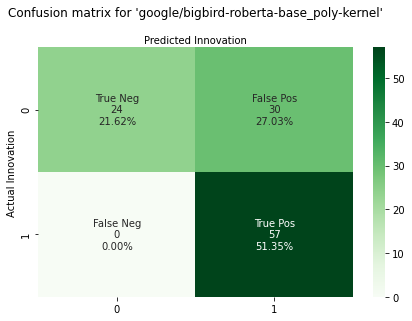

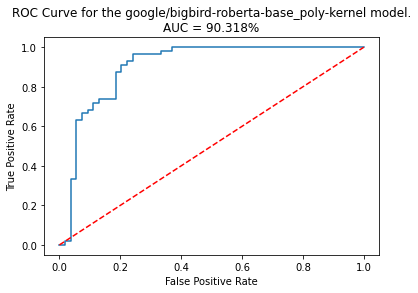


========= google/bigbird-roberta-base_rbf-kernel model ==========

Accuracy of the of the google/bigbird-roberta-base_rbf-kernel model is 87.39%.
Precision rate of the google/bigbird-roberta-base_rbf-kernel model is 82.09%.
Recall rate of the google/bigbird-roberta-base_rbf-kernel model is 96.49%.
F-1 score of the google/bigbird-roberta-base_rbf-kernel model is 88.71%.

The confusion matrix for the google/bigbird-roberta-base_rbf-kernel model is:


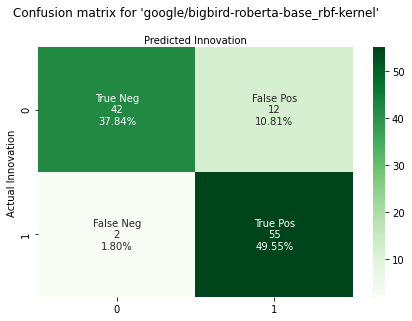

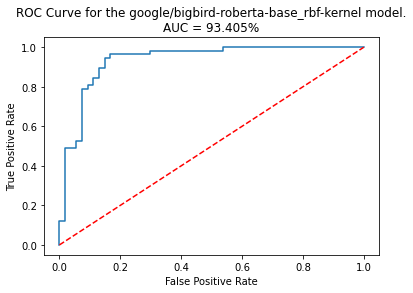


========= google/bigbird-roberta-base_sigmoid-kernel model ==========

Accuracy of the of the google/bigbird-roberta-base_sigmoid-kernel model is 88.29%.
Precision rate of the google/bigbird-roberta-base_sigmoid-kernel model is 84.38%.
Recall rate of the google/bigbird-roberta-base_sigmoid-kernel model is 94.74%.
F-1 score of the google/bigbird-roberta-base_sigmoid-kernel model is 89.26%.

The confusion matrix for the google/bigbird-roberta-base_sigmoid-kernel model is:


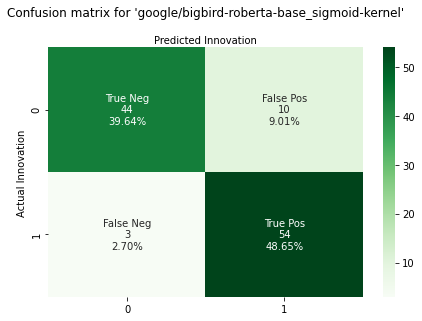

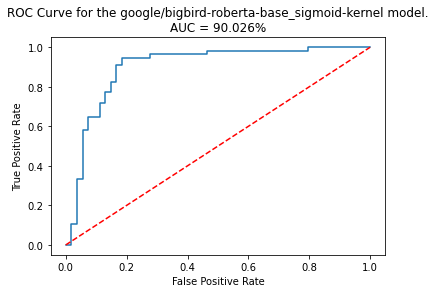


========= google/bigbird-roberta-large_linear-kernel model ==========

Accuracy of the of the google/bigbird-roberta-large_linear-kernel model is 81.08%.
Precision rate of the google/bigbird-roberta-large_linear-kernel model is 76.47%.
Recall rate of the google/bigbird-roberta-large_linear-kernel model is 91.23%.
F-1 score of the google/bigbird-roberta-large_linear-kernel model is 83.2%.

The confusion matrix for the google/bigbird-roberta-large_linear-kernel model is:


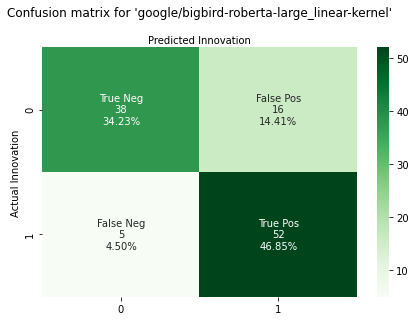

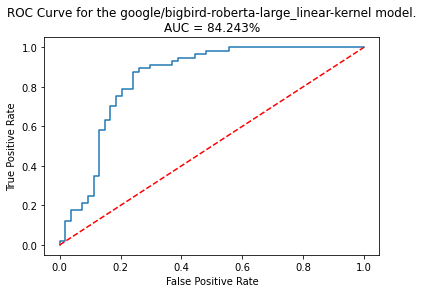


========= google/bigbird-roberta-large_poly-kernel model ==========

Accuracy of the of the google/bigbird-roberta-large_poly-kernel model is 86.49%.
Precision rate of the google/bigbird-roberta-large_poly-kernel model is 85.0%.
Recall rate of the google/bigbird-roberta-large_poly-kernel model is 89.47%.
F-1 score of the google/bigbird-roberta-large_poly-kernel model is 87.18%.

The confusion matrix for the google/bigbird-roberta-large_poly-kernel model is:


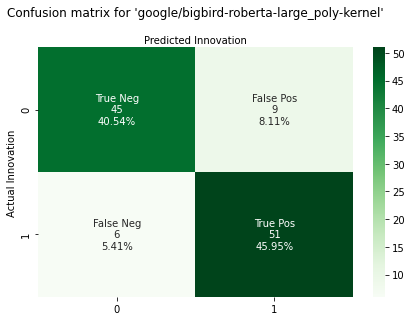

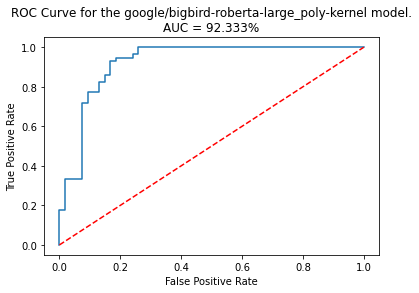


========= google/bigbird-roberta-large_rbf-kernel model ==========

Accuracy of the of the google/bigbird-roberta-large_rbf-kernel model is 84.68%.
Precision rate of the google/bigbird-roberta-large_rbf-kernel model is 80.3%.
Recall rate of the google/bigbird-roberta-large_rbf-kernel model is 92.98%.
F-1 score of the google/bigbird-roberta-large_rbf-kernel model is 86.18%.

The confusion matrix for the google/bigbird-roberta-large_rbf-kernel model is:


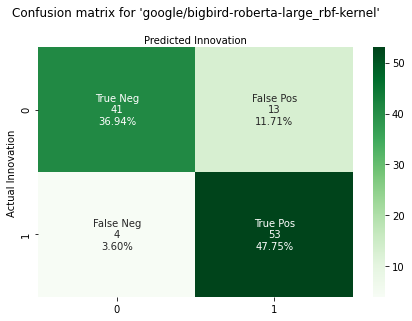

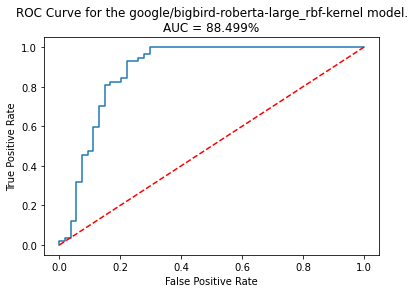


========= google/bigbird-roberta-large_sigmoid-kernel model ==========

Accuracy of the of the google/bigbird-roberta-large_sigmoid-kernel model is 83.78%.
Precision rate of the google/bigbird-roberta-large_sigmoid-kernel model is 80.0%.
Recall rate of the google/bigbird-roberta-large_sigmoid-kernel model is 91.23%.
F-1 score of the google/bigbird-roberta-large_sigmoid-kernel model is 85.25%.

The confusion matrix for the google/bigbird-roberta-large_sigmoid-kernel model is:


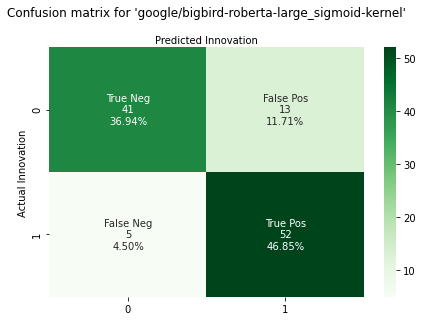

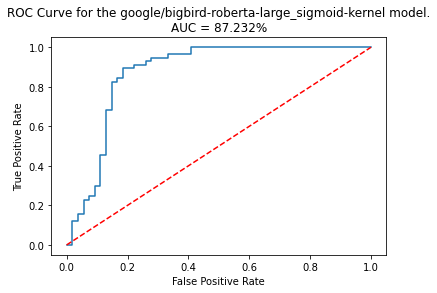

In [14]:
labels = df.YN_INNOVATION ## Target variable

for key in test_labels_predict_dict.keys():
    print("\n=========",key, "model ==========\n")
    key0 = str.split(key, "_")[0]
    
    # Metrics
    accuracy = metrics.accuracy_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    precision=metrics.precision_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    recall=metrics.recall_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    f1_score = metrics.f1_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    
    print("Accuracy of the of the", key ,"model is {}%.".format(round((accuracy*100),2)))
    print("Precision rate of the", key, "model is {}%.".format(round((precision*100),2)))
    print("Recall rate of the", key, "model is {}%.".format(round((recall*100),2)))
    print("F-1 score of the", key, "model is {}%.".format(round((f1_score*100),2)))
    #print("The Cross Validation Score of the", key, "model is {}%".format(round(cv_scores_dict[key]*100, 2)))
    
    # Confusion Matrix
    print("\nThe confusion matrix for the", key,"model is:")
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]).flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]).flatten()/np.sum(metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]), annot=labels, fmt='', cmap='Greens')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix for %r'%key, y=1.1)
    plt.ylabel('Actual Innovation')
    plt.xlabel('Predicted Innovation')
    plt.show()
    
    
    # ROC Graph
    fpr, tpr, thresholds = roc_curve(test_labels_dict[key0], test_labels_predict_proba_dict[key])
    auc = roc_auc_score(test_labels_dict[key0], test_labels_predict_proba_dict[key])

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', color="red")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for the "+key+" model.\nAUC = "+str(round(auc*100, 3))+"%")
    plt.show()

In [17]:
metrics_dict = {}

for key in test_labels_predict_dict.keys():
    key0 = str.split(key, "_")[0]
    accuracy = metrics.accuracy_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    precision=metrics.precision_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    recall=metrics.recall_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    f1_score = metrics.f1_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    auc = roc_auc_score(test_labels_dict[key0], test_labels_predict_proba_dict[key])
    #cv_score = cv_scores_dict[key]
    
    true_neg = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[0][0]
    false_pos = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[0][1]
    false_neg = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[1][0]
    true_pos = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[1][1]
    
    
    metrics_dict.update({key:{"accuracy": accuracy, 
                              "precision": precision, 
                              "recall": recall, 
                              "f1_score": f1_score, 
                              "auc": auc,
                              #"cross_val_score_600_obs": cv_score,
                              "true_positive": true_pos,
                              "true_negative": true_neg, 
                              "false_positive": false_pos,
                              "false_negative": false_neg}})

In [18]:
pd.DataFrame(metrics_dict).T

accuracy  precision    recall  \
bert-base-cased_linear-kernel                0.783784   0.800000  0.771930   
bert-base-cased_poly-kernel                  0.675676   0.640000  0.842105   
bert-base-cased_rbf-kernel                   0.810811   0.800000  0.842105   
bert-base-cased_sigmoid-kernel               0.801802   0.769231  0.877193   
bert-base-uncased_linear-kernel              0.792793   0.765625  0.859649   
bert-base-uncased_poly-kernel                0.765766   0.696203  0.964912   
bert-base-uncased_rbf-kernel                 0.792793   0.774194  0.842105   
bert-base-uncased_sigmoid-kernel             0.819820   0.768116  0.929825   
bert-large-cased_linear-kernel               0.729730   0.728814  0.754386   
bert-large-cased_poly-kernel                 0.594595   0.772727  0.298246   
bert-large-cased_rbf-kernel                  0.783784   0.753846  0.859649   
bert-large-cased_sigmoid-kernel              0.774775   0.785714  0.771930   
bert-large-uncased_linear-kernel             0.774775   0.750000  0.842105   
bert-large-uncased_poly-kernel               0.747748   0.674699  0.982456   
bert-large-uncased_rbf-kernel                0.747748   0.737705  0.789474   
bert-large-uncased_sigmoid-kernel            0.729730   0.701493  0.824561   
distilbert-base-cased_linear-kernel          0.765766   0.771930  0.771930   
distilbert-base-cased_poly-kernel            0.684685   0.619565  1.000000   
distilbert-base-cased_rbf-kernel             0.837838   0.782609  0.947368   
distilbert-base-cased_sigmoid-kernel         0.837838   0.791045  0.929825   
distilbert-base-uncased_linear-kernel        0.819820   0.824561  0.824561   
distilbert-base-uncased_poly-kernel          0.783784   0.703704  1.000000   
distilbert-base-uncased_rbf-kernel           0.900901   0.838235  1.000000   
distilbert-base-uncased_sigmoid-kernel       0.891892   0.835821  0.982456   
roberta-base_linear-kernel                   0.783784   0.779661  0.807018   
roberta-base_poly-kernel                     0.711712   0.643678  0.982456   
roberta-base_rbf-kernel                      0.819820   0.784615  0.894737   
roberta-base_sigmoid-kernel                  0.828829   0.796875  0.894737   
roberta-large_linear-kernel                  0.810811   0.810345  0.824561   
roberta-large_poly-kernel                    0.666667   0.606383  1.000000   
roberta-large_rbf-kernel                     0.819820   0.784615  0.894737   
roberta-large_sigmoid-kernel                 0.774775   0.742424  0.859649   
distilroberta-base_linear-kernel             0.774775   0.742424  0.859649   
distilroberta-base_poly-kernel               0.747748   0.670588  1.000000   
distilroberta-base_rbf-kernel                0.846847   0.794118  0.947368   
distilroberta-base_sigmoid-kernel            0.864865   0.818182  0.947368   
facebook/bart-base_linear-kernel             0.738739   0.725806  0.789474   
facebook/bart-base_poly-kernel               0.756757   0.697368  0.929825   
facebook/bart-base_rbf-kernel                0.792793   0.750000  0.894737   
facebook/bart-base_sigmoid-kernel            0.801802   0.761194  0.894737   
google/bigbird-roberta-base_linear-kernel    0.792793   0.783333  0.824561   
google/bigbird-roberta-base_poly-kernel      0.729730   0.655172  1.000000   
google/bigbird-roberta-base_rbf-kernel       0.873874   0.820896  0.964912   
google/bigbird-roberta-base_sigmoid-kernel   0.882883   0.843750  0.947368   
google/bigbird-roberta-large_linear-kernel   0.810811   0.764706  0.912281   
google/bigbird-roberta-large_poly-kernel     0.864865   0.850000  0.894737   
google/bigbird-roberta-large_rbf-kernel      0.846847   0.803030  0.929825   
google/bigbird-roberta-large_sigmoid-kernel  0.837838   0.800000  0.912281   

                                             f1_score       auc  \
bert-base-cased_linear-kernel                0.785714  0.878493   
bert-base-cased_poly-kernel                  0.727273  0.820338   
bert-base-cased_rbf-k

In [19]:
## Saving SVM Model metrics to DataFrame
pd.DataFrame(metrics_dict).T.to_csv("/project/class/bii_sdad_dspg/uva_2021/binn/svm_model_metrics.csv")

In [17]:
## Saving a dataframe of the data with predicted labels from models
pred_df = pd.DataFrame(test_labels_predict_dict, index = test_labels_dict['distilbert-base-cased'].index)
pd.concat([df.iloc[test_labels_dict['distilbert-base-cased'].index,], pred_df], axis=1).to_csv("/project/class/bii_sdad_dspg/uva_2021/binn/svm_test_data_comparison.csv")